In [1]:
import pm4py
import os

bpmn_graph = pm4py.read_bpmn("../configurations/AS-IS-startup-bakery-startup-workflow.bpmn")

In [2]:
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

petri_net, im, fm = bpmn_converter.apply(bpmn_graph)

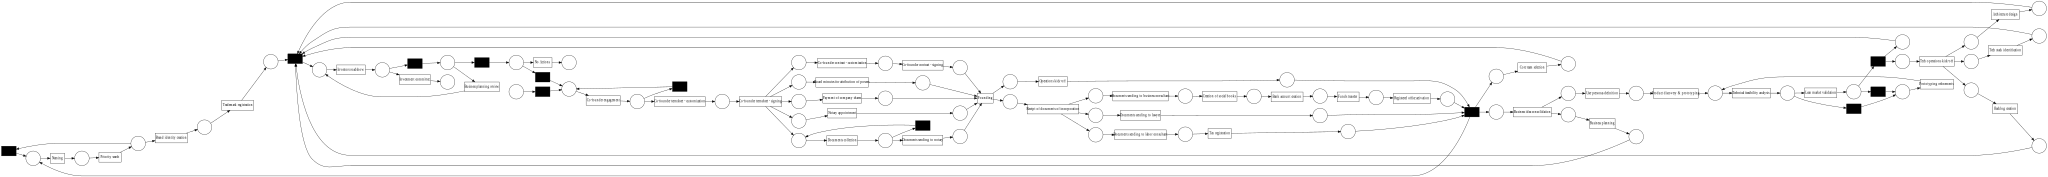

In [3]:
from pm4py.visualization.petri_net import visualizer as petri_visualizer
petri_visualizer.apply(petri_net)

In [4]:
# importing the module
import ast

with open('../configurations/AS-IS-time_constraints.txt', "r") as time_constraints:
    time_constraints = [ast.literal_eval(line) for line in time_constraints][0]

with open('../configurations/AS-IS-antecedents.txt', "r") as antecedents:
    antecedents = [ast.literal_eval(line) for line in antecedents][0]

In [5]:
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.filtering.pandas.attr_value_repetition import filter
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd

simulated_log = simulator.apply(petri_net, im, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 200, simulator.Variants.BASIC_PLAYOUT.value.Parameters.TIME_CONSTRAINTS:time_constraints, simulator.Variants.BASIC_PLAYOUT.value.Parameters.ANTECEDENTS:antecedents, simulator.Variants.BASIC_PLAYOUT.value.Parameters.RANDOMNESS_OF_TIMESTAMP: 0.2})   
log_csv = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)

#Here we filter out the traces that are supposed to be aletich
valid_traces = filter.apply(log_csv, value = "Co-founder engagement", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Documents collection", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Naming", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Investors roadshow", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 2})
valid_traces = filter.apply(valid_traces, value = "Prototyping refinements", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 3})
valid_traces = filter.apply(valid_traces, value = "Lean market validation", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 2})

simulated_log = log_converter.apply(valid_traces)

In [6]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
dataframe = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)
#dataframe.to_csv('../data/AS-IS-valid_traces.csv')

In [7]:
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('../data/AS-IS-valid_traces.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
simulated_log = log_converter.apply(log_csv)

In [8]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(simulated_log, petri_net, im, fm)

In [11]:
"""
    Parameters:
        log: the log with all the traces (each event contains a start timestamp and an end timestamp)
        time_constraints: this is a dictionary where each key is an activity of the given process model
                          and the value indicates the time normally needed to make such activity (expressed in days).
        target_trace_duration: This indicates the ideal time needed to accomplish a trace (expressed in days)
        tolerance: This is used as an upper bound for the time divergence of a trace w.r.t the target_trace_duration
        ending_activities: which are the activities that
    Return:
        A list of metrics related to each trace in the log:
        Such trace's metrics are stored in a dict:
        trace_dict : {
                        'not_timely_activities' : number of activities that exceeded the time constraints,
                        'timely_activities' : number of activities that didn't exceed the time constraints,
                        'timely_activities' : number of activities that didn't exceed the time constraints,
                        'time_accuracy': the fraction of activities that didn't exceeded the time constraints w.r.t the total activities executed,
                        'trace_time_divergence': the time saved or wasted w.r.t the target_trace_duration (expressed in days),
                        'proccess_failure' : the fraction of the time wasted w.r.t to the tolerance,
                        'events': [{...}]
                    }
"""
def get_conformance_time(log, time_constraints, target_trace_duration, tolerance = 0, ending_activities = None, no_blocking_activities = [], activities_in_loop=[], antecedents = None):
    
    conformance_time_traces = []
    for trace in log:
        trace_dict = {}
        #This dict is used to take track of the time execution in each point of the timeline
        activities_dict = {}
        trace_dict['not_timely_activities'] = 0
        trace_dict['timely_activities'] = 0
        
        events = []
        time_accumulation = 0
        for i, activity in enumerate(trace):
            record = {}
            
            tc = time_constraints[activity['concept:name']]
            start_timestamp = activity['time:timestamp']
            end_timestamp = activity['end_timestamp']
            activity_name = activity['concept:name']
            
            record['concept:name'] = activity_name
            record['start_timestamp'] = start_timestamp
            record['end_timestamp'] = end_timestamp
            
            time_spent = (end_timestamp - start_timestamp).total_seconds()
            time_spent_in_days = time_spent/60/60/24
            time_divergence = time_spent - tc*60*60*24
            record['time_divergence'] = round(time_spent/60/60/24 - tc, 2)
            
            if activities_dict.get(activity_name) is None:
                activities_dict[activity_name] = {}
                activities_dict[activity_name]['tc_accumulation'] = time_accumulation
                activities_dict[activity_name]['duration_of_execution'] = time_spent_in_days
                activities_dict[activity_name]['end_timestamp'] = end_timestamp

            #retrieve the last events processed of the first antecedents of the current activity
            last_antecedent_events = [activities_dict[antecedent] for antecedent in antecedents[activity['concept:name']] if activities_dict.get(antecedent) is not None]
            if len(last_antecedent_events) != 0:
                #select the latest event of between the antecedents  
                latest_event = max(last_antecedent_events, key = lambda p: p['end_timestamp'])
                time_accumulation = latest_event['tc_accumulation'] + tc
                
                activities_dict[activity_name]['tc_accumulation'] = latest_event['tc_accumulation'] + tc
                if activities_dict[activity_name]['tc_accumulation'] > target_trace_duration:
                    activities_dict[activity_name]['tc_accumulation'] = target_trace_duration
                    
                activities_dict[activity_name]['duration_of_execution'] = latest_event['duration_of_execution'] + time_spent_in_days
            else:
                activities_dict[activity_name]['tc_accumulation'] = tc
                activities_dict[activity_name]['duration_of_execution'] = time_spent_in_days
                time_accumulation = tc

            time_divergence =  activities_dict[activity_name]['duration_of_execution'] - activities_dict[activity['concept:name']]['tc_accumulation'] 
            if time_divergence <= 0:
                record['process_failure'] = 0
            else:
                record['process_failure'] = round(time_divergence / tolerance, 2)
                    
            if time_spent > tc*60*60*24:
                record['time_is_fit'] = False
                trace_dict['not_timely_activities'] += 1
            if time_spent <= tc*60*60*24:
                record['time_is_fit'] = True
                trace_dict['timely_activities'] += 1
            events.sort(key = lambda x: x['end_timestamp'])
            events.append(record)
            
        last_event = [activities_dict[x] for x in ending_activities if activities_dict.get(x) is not None][0]
        trace_dict['trace_time_duration'] = round(last_event['duration_of_execution'], 2) 
        trace_dict['trace_time_divergence'] = round(trace_dict['trace_time_duration'] - target_trace_duration, 2)
        trace_dict['time_accuracy'] = round(trace_dict['timely_activities'] /  (trace_dict['timely_activities'] + trace_dict['not_timely_activities']), 2)
        trace_dict['process_failure'] = round(trace_dict['trace_time_divergence'] / tolerance, 2)
        if trace_dict['process_failure'] < 0:
            trace_dict['process_failure'] = 0
        trace_dict['events'] = events
        conformance_time_traces.append(trace_dict)

    return conformance_time_traces
                    

In [12]:
ending_activities = ['No Actions', 'Investment committee']
conformance_on_time = get_conformance_time(simulated_log, time_constraints, target_trace_duration = 180, tolerance = 60, ending_activities = ending_activities, antecedents = antecedents)

In [13]:
conformance_on_time

[{'not_timely_activities': 21,
  'timely_activities': 27,
  'trace_time_duration': 191.9,
  'trace_time_divergence': 11.9,
  'time_accuracy': 0.56,
  'process_failure': 0.2,
  'events': [{'concept:name': 'Co-founder engagement',
    'start_timestamp': Timestamp('1970-01-01 01:01:32+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-02 04:21:06+0000', tz='UTC'),
    'time_divergence': 0.14,
    'process_failure': 0.02,
    'time_is_fit': False},
   {'concept:name': 'Co-founder engagement',
    'start_timestamp': Timestamp('1970-01-02 04:21:06+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-02 23:55:59+0000', tz='UTC'),
    'time_divergence': -0.18,
    'process_failure': 0.02,
    'time_is_fit': True},
   {'concept:name': 'Co-founder engagement',
    'start_timestamp': Timestamp('1970-01-02 23:55:59+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-03 20:43:55+0000', tz='UTC'),
    'time_divergence': -0.13,
    'process_failure': 0.02,
    'time_is_fit': True},


In [14]:
import numpy as np
average_results = {}
average_results['process_failure'] = np.mean([trace['process_failure'] for trace in conformance_on_time])
average_results['time_divergence'] = np.mean([trace['trace_time_divergence'] for trace in conformance_on_time])
average_results['trace_time_duration'] = np.mean([trace['trace_time_duration'] for trace in conformance_on_time])
average_results['number_of_activities'] = np.mean([len(trace['events'])  for trace in conformance_on_time])
average_results['time_accuracy'] = np.mean([trace['time_accuracy']  for trace in conformance_on_time])

In [15]:
average_results

{'process_failure': 0.43183673469387757,
 'time_divergence': 23.26265306122449,
 'trace_time_duration': 203.2626530612245,
 'number_of_activities': 46.51020408163265,
 'time_accuracy': 0.4959183673469388}

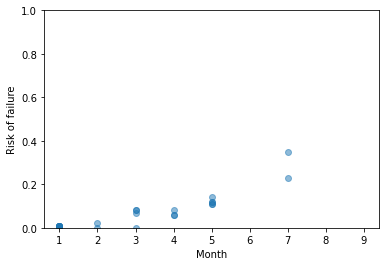

In [16]:
import numpy as np
import matplotlib.pyplot as plt

trace = conformance_on_time[4]['events']
y = [event['process_failure'] for event in trace]
x = [event['end_timestamp'].month for event in trace]

plt.scatter(x, y, alpha=0.5)
plt.ylim(0, 1);
plt.ylabel("Risk of failure")
plt.xlabel("Month")
plt.show()

In [41]:

activities_dict = {}
for trace in simulated_log:
    for i, activity in enumerate(trace):
        record = {}
        if activities_dict.get(activity['concept:name']) is None:
            activities_dict[activity['concept:name']] = {}
            activities_dict[activity['concept:name']] = 0
        else:
            activities_dict[activity['concept:name']] += 1
                    

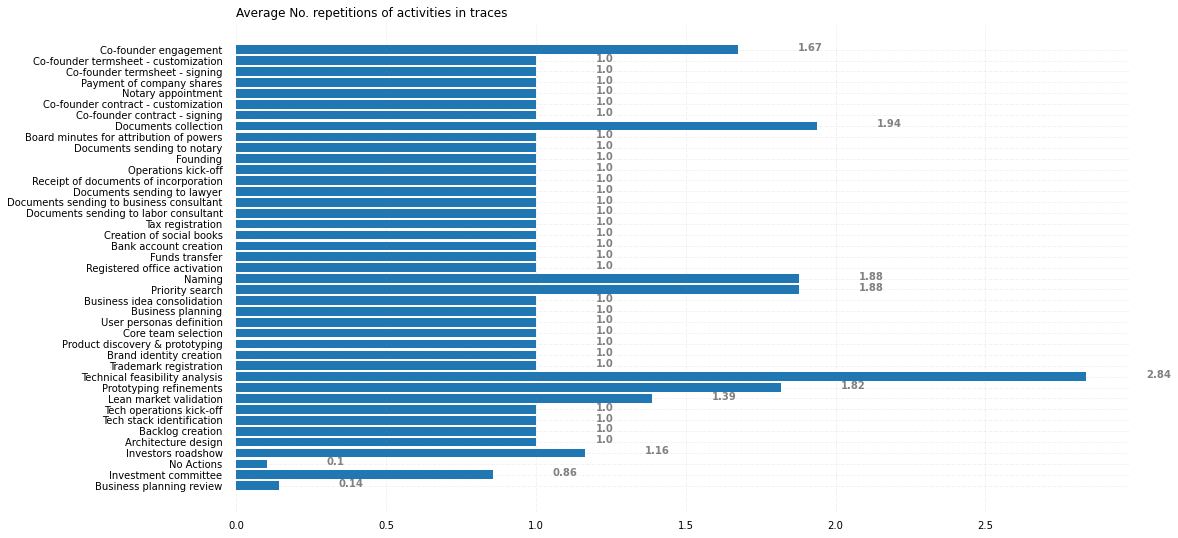

In [70]:
import pandas as pd
from matplotlib import pyplot as plt
 

activities = list(activities_dict.keys())
values = [value / len(simulated_log) for value in activities_dict.values()]   
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(activities, values)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Average No. repetitions of activities in traces',
             loc ='left', )
 
# Show Plot
plt.show()